In [10]:
import os
import re
import json
import pandas as pd
import uuid
from datetime import datetime
from google.colab import files
import graphviz

#############################################
# Step 0: Utility – Get Raw Log File Path
#############################################
def get_raw_log_file():
    use_existing = input("Do you want to use an existing raw log file? (Y/N): ").strip().lower()
    if use_existing == "y":
        filename = input("Enter the full path (or file name) of the raw log file: ").strip()
        if os.path.exists(filename):
            print(f"Using existing raw log file: {filename}")
            return filename
        else:
            print("File not found. Please upload a new log file.")
    # If not using existing file or file not found, upload a new file.
    print("Please upload your raw GNBSIM log file (e.g., gnbsimwith1Ue.log).")
    uploaded = files.upload()
    filename = list(uploaded.keys())[0]
    print(f"Using uploaded file: {filename}")
    return filename

#############################################
# Step 1: Preprocessing Function
#############################################
def preprocess_logs(input_file: str, output_file: str) -> pd.DataFrame:
    pattern = re.compile(
        r'^(?P<timestamp>\S+)\t'
        r'(?P<level>\S+)\t'
        r'(?P<module>[^:]+):(?P<line_number>\d+)\t'
        r'(?P<message>[^\t]+)'
        r'(?:\t(?P<structured_data>\{.*\}))?$'
    )

    def extract_metrics(msg: str) -> dict:
        out = {}
        ue_match = re.search(r'UE:\s*(\S+)', msg)
        if ue_match:
            out["ue"] = ue_match.group(1)
        for k, v in re.findall(r'([\w\[\]]+):\s*(\d+)', msg):
            col = k.replace('[us]', '_us').replace('[', '_').replace(']', '')
            out[col] = int(v)
        return out

    parsed = []
    with open(input_file, encoding='utf-8') as f:
        for i, line in enumerate(f, 1):
            line = line.rstrip('\n')
            m = pattern.match(line)
            if m:
                gd = m.groupdict()
                entry = {
                    "timestamp": gd["timestamp"],
                    "level": gd["level"],
                    "module": gd["module"],
                    "line_number": int(gd["line_number"]),
                    "message": gd["message"]
                }
                sd = {}
                if gd.get("structured_data"):
                    try:
                        sd = json.loads(gd["structured_data"])
                    except json.JSONDecodeError:
                        print(f"Bad JSON at line {i}")
                for key in ("component", "category", "subcategory", "supi", "profile",
                            "ranuengapid", "dlteid", "pdusessid"):
                    entry[key] = sd.get(key)
                entry.update(extract_metrics(entry["message"]))
                parsed.append(entry)
            else:
                stripped = line.strip()
                if stripped.startswith("{") and stripped.endswith("}"):
                    try:
                        json_data = json.loads(stripped)
                        entry = {
                            "timestamp": None,
                            "level": None,
                            "module": None,
                            "line_number": None,
                            "message": None,
                            "structured_data": json_data
                        }
                        for key in ("component", "category", "subcategory", "supi", "profile",
                                    "ranuengapid", "dlteid", "pdusessid"):
                            entry[key] = json_data.get(key)
                        parsed.append(entry)
                    except json.JSONDecodeError:
                        print(f"Error parsing JSON at line {i}: {line}")
                else:
                    print(f"Skipped line {i}: no match")
    df = pd.DataFrame(parsed)
    df.to_csv(output_file, index=False)
    print(f"Wrote {len(df)} rows to {output_file}")
    return df

#############################################
# Step 2: Load or Upload Raw Log and Preprocess
#############################################
raw_log_filename = get_raw_log_file()
raw_basename = os.path.splitext(os.path.basename(raw_log_filename))[0]
preprocessed_filename = f"preprocessed-{raw_basename}.csv"
if os.path.exists(preprocessed_filename):
    print(f"{preprocessed_filename} found. Loading it...")
    df = pd.read_csv(preprocessed_filename)
else:
    df = preprocess_logs(raw_log_filename, preprocessed_filename)

#############################################
# Step 3: Improve Log Format
#############################################
def improve_log_format(df: pd.DataFrame) -> list:
    improved_logs = []
    for idx, row in df.iterrows():
        improved = {}
        improved["timestamp"] = row["timestamp"]
        improved["level"] = row["level"]
        improved["module"] = row["module"]
        improved["line_number"] = row["line_number"]
        improved["message"] = row["message"]

        imsi = row.get("ue") or row.get("supi")
        if imsi and isinstance(imsi, str):
            improved["imsi"] = re.sub(r'[,; ]+', '', imsi.lower().strip())
        else:
            improved["imsi"] = None

        profile = row.get("profile")
        if profile and isinstance(profile, str):
            improved["profile"] = profile.strip().lower()
        else:
            improved["profile"] = None

        metrics = {}
        metrics_sec = {}
        for col in row.index:
            if isinstance(col, str) and col.endswith("_us") and pd.notna(row[col]):
                metrics[col] = row[col]
                metrics_sec[col] = row[col] / 1e6
        improved["metrics"] = {"us": metrics, "sec": metrics_sec}

        if row["message"] and "execute procedure" in row["message"].lower():
            improved["correlation_id"] = str(uuid.uuid4())
        else:
            improved["correlation_id"] = None

        improved_logs.append(improved)
    return improved_logs

improved_filename = f"improved-{raw_basename}.jsonl"
if os.path.exists(improved_filename):
    print(f"{improved_filename} found. Using it...")
else:
    improved_logs = improve_log_format(df)
    with open(improved_filename, "w", encoding="utf-8") as f:
        for log in improved_logs:
            f.write(json.dumps(log) + "\n")
    print(f"Improved logs saved to {improved_filename}")

#############################################
# Step 4: Define Analysis Functions and Mappings
#############################################
procedure_to_metric = {
    "REGISTRATION_PROCEDURE": "TotalRegTime",
    "PDU_SESSION_ESTABLISHMENT_PROCEDURE": "TotalPduEstTime",
    "UE_INITIATED_DEREGISTRATION_PROCEDURE": "TotalDeregistrationTime",
    "UE_REQUESTED_PDU_SESSION_RELEASE_PROCEDURE": "TotalCtxReleaseTime",
    "UE_TRIGGERED_SERVICE_REQUEST_PROCEDURE": "TotalServiceReqTime",
}

def load_logs(df: pd.DataFrame) -> pd.DataFrame:
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
    if 'supi' not in df.columns and 'imsi' in df.columns:
        df['supi'] = df['imsi'].fillna("").str.lower().str.strip()
        df['supi'] = df['supi'].str.replace(r'[,; ]+', '', regex=True)
    else:
        df['supi'] = df['supi'].fillna("").str.lower().str.strip()
        df['supi'] = df['supi'].str.replace(r'[,; ]+', '', regex=True)
    if 'imsi' in df.columns:
        df['imsi'] = df['imsi'].fillna("").str.lower().str.strip()
        df['imsi'] = df['imsi'].str.replace(r'[,; ]+', '', regex=True)
    return df

def list_available_procedures(df, imsi=None):
    filtered = df.copy()
    if imsi:
        filtered = filtered[filtered['supi'] == imsi]
    proc_pattern = re.compile(r'\b[A-Z0-9]+(?:-[A-Z0-9]+)+\b')
    procedures = []
    for msg in filtered['message'].dropna():
        for proc in proc_pattern.findall(msg):
            if re.match(r'\d{4}-\d{2}-\d{2}', proc):
                continue
            if proc not in procedures:
                procedures.append(proc)
    return procedures

def get_call_flow(df, imsi=None, procedure_keyword=None):
    filtered = df.copy()
    if imsi:
        filtered = filtered[filtered['supi'] == imsi]
    if procedure_keyword:
        filtered = filtered[filtered['message'].fillna('').str.contains(procedure_keyword, case=False, na=False)]
    filtered['timestamp'] = pd.to_datetime(filtered['timestamp'], errors='coerce')
    filtered = filtered.dropna(subset=['timestamp'])
    call_flow = filtered.sort_values('timestamp')
    latency = None
    if len(call_flow) >= 2:
        latency = call_flow['timestamp'].iloc[-1] - call_flow['timestamp'].iloc[0]
    return call_flow, latency

def list_logs_by_imsi(df, imsi):
    filtered = df[df['supi'] == imsi]
    if filtered.empty:
        print(f"No logs found for IMSI {imsi}.")
    else:
        cols = ['timestamp', 'level', 'module', 'message']
        if 'structured_data' in filtered.columns:
            cols.append('structured_data')
        print(filtered[cols].to_string(index=False))

def compute_procedure_latencies(df: pd.DataFrame):
    rows = []
    for idx, row in df.iterrows():
        imsi = row.get("ue") or row.get("supi")
        if not (isinstance(imsi, str) and imsi):
            continue
        imsi = imsi.lower().strip()
        for proc, metric_prefix in procedure_to_metric.items():
            col_name = metric_prefix + "_us"
            if col_name in df.columns and pd.notna(row.get(col_name)):
                rows.append({
                    "imsi": imsi,
                    "procedure": proc,
                    "latency_us": row[col_name]
                })
    return pd.DataFrame(rows)

def summarize_procedure_latencies(latency_df: pd.DataFrame):
    if latency_df.empty:
        print("\nNo procedure latencies found.")
        return
    latency_df = latency_df.copy()
    latency_df['latency_sec'] = latency_df['latency_us'] / 1e6
    print("\nPer-IMSI Procedure Latencies:")
    print(latency_df.to_string(index=False))

    grouped = latency_df.groupby("procedure").agg(
        count=("latency_us", "count"),
        avg_latency_us=("latency_us", "mean")
    ).reset_index()
    grouped['avg_latency_sec'] = grouped['avg_latency_us'] / 1e6
    grouped = grouped.sort_values("count", ascending=False)
    print("\nProcedure Latency Summary (sorted by occurrence):")
    print(grouped.to_string(index=False))

#############################################
# New Helper Functions for IMSI-Based Call Flow
#############################################
def list_unique_imsis(df: pd.DataFrame) -> list:
    # Filter out empty strings and then sort.
    imsis = [im for im in df['supi'].dropna().unique() if im.strip() != ""]
    return sorted(imsis)

def export_call_flow_pdf(df: pd.DataFrame, imsi: str, filename_prefix="call_flow"):
    """
    Generates a call flow diagram for a specific IMSI using Graphviz,
    and saves it as a PDF at 300 dpi with a title.
    """
    sub = df[df['supi'] == imsi].copy()
    sub['timestamp'] = pd.to_datetime(sub['timestamp'], errors='coerce')
    sub = sub.dropna(subset=['timestamp']).sort_values('timestamp')
    if sub.empty:
        print(f"No events found for IMSI {imsi}.")
        return

    d = graphviz.Digraph(format='pdf')
    d.attr(dpi='300')
    d.attr(label=f"Call Flow for {imsi}", labelloc='t', fontsize='20')

    for idx, row in sub.iterrows():
        ts = row['timestamp'].strftime('%H:%M:%S')
        msg = row['message'] or ""
        label = f"{ts}\n{msg[:30]}..." if len(msg) > 30 else f"{ts}\n{msg}"
        d.node(str(idx), label, shape='box', style='filled', fillcolor='lightblue')

    node_ids = list(map(str, sub.index))
    for i in range(len(node_ids) - 1):
        d.edge(node_ids[i], node_ids[i+1])

    pdf_path = d.render(filename=f"{filename_prefix}-{imsi}", cleanup=True)
    print(f"PDF saved: {pdf_path}")

def view_imsi_call_flow(df: pd.DataFrame):
    unique_imsis = list_unique_imsis(df)
    if not unique_imsis:
        print("No IMSIs found in the logs.")
        return

    print("\nAvailable IMSIs:")
    for i, imsi in enumerate(unique_imsis, start=1):
        print(f"{i}. {imsi}")

    try:
        choice = int(input("Enter the number corresponding to the IMSI you want to view: ").strip())
        if choice < 1 or choice > len(unique_imsis):
            print("Invalid selection.")
            return
        selected_imsi = unique_imsis[choice - 1]
    except ValueError:
        print("Please enter a valid number.")
        return

    call_flow, latency = get_call_flow(df, imsi=selected_imsi)
    if call_flow.empty:
        print(f"No call flow found for IMSI {selected_imsi}.")
    else:
        print(f"\nCall Flow for IMSI '{selected_imsi}':")
        display_cols = ['message']
        print(call_flow[display_cols].to_string(index=False))
        if latency:
            print(f"\nTotal Latency: {latency} ({latency.total_seconds()} seconds)")
        else:
            print("\nNot enough events to calculate latency.")
        # Now export the PDF for the selected IMSI:
        export_call_flow_pdf(df, selected_imsi)

#############################################
# Step 5: Interactive Menu
#############################################
def interactive_menu(df):
    df = load_logs(df)
    while True:
        print("\n===== GNBSIM Improved Log Analysis Menu =====")
        print("1. View call flow for a procedure")
        print("2. List available procedures")
        print("3. Search logs by IMSI")
        print("4. View procedure latency summary (detailed & summary)")
        print("5. View call flow by IMSI")  # New option for IMSI-based call flow
        print("6. Exit")
        choice = input("Enter your choice (1-6): ").strip()

        if choice == "1":
            imsi_input = input("Enter IMSI (without 'imsi-' prefix, leave blank for all): ").strip()
            if imsi_input:
                imsi = "imsi-" + imsi_input if not imsi_input.lower().startswith("imsi-") else imsi_input.lower()
            else:
                imsi = None
            available_procs = list_available_procedures(df, imsi=imsi)
            if not available_procs:
                resp = input("No procedures found for the specified IMSI. View procedures for all UEs? (Y/N): ").strip().lower()
                if resp == "y":
                    imsi = None
                    available_procs = list_available_procedures(df)
                else:
                    continue
            print("\nAvailable procedures:")
            for i, proc in enumerate(available_procs, start=1):
                print(f"{i}. {proc}")
            proc_choice = input("Enter the number corresponding to the procedure to view: ").strip()
            try:
                idx = int(proc_choice) - 1
                if idx < 0 or idx >= len(available_procs):
                    print("Invalid procedure selection.")
                    continue
                selected_proc = available_procs[idx]
                call_flow, latency = get_call_flow(df, imsi=imsi, procedure_keyword=selected_proc)
                print(f"\nCall Flow for procedure '{selected_proc}':")
                if call_flow.empty:
                    print("No events found for this procedure.")
                else:
                    cols = ['timestamp','level','module','message']
                    if 'structured_data' in call_flow.columns:
                        cols.append('structured_data')
                    print(call_flow[cols].to_string(index=False))
                    if latency:
                        print(f"\nTotal Latency: {latency} ({latency.total_seconds()} seconds)")
                    else:
                        print("\nNot enough events to calculate latency.")
            except ValueError:
                print("Please enter a valid number.")

        elif choice == "2":
            available_procs = list_available_procedures(df)
            if not available_procs:
                print("No procedures found.")
            else:
                print("\nAvailable procedures:")
                for proc in available_procs:
                    print(proc)

        elif choice == "3":
            imsi_input = input("Enter IMSI (without 'imsi-' prefix): ").strip()
            if imsi_input:
                imsi = "imsi-" + imsi_input if not imsi_input.lower().startswith("imsi-") else imsi_input.lower()
                print(f"\nLogs for IMSI {imsi}:")
                list_logs_by_imsi(df, imsi)
            else:
                print("No IMSI entered.")

        elif choice == "4":
            latency_df = compute_procedure_latencies(df)
            summarize_procedure_latencies(latency_df)

        elif choice == "5":
            view_imsi_call_flow(df)

        elif choice == "6":
            print("Exiting.")
            break

        else:
            print("Invalid choice. Please try again.")



Do you want to use an existing raw log file? (Y/N): y
Enter the full path (or file name) of the raw log file: /content/drive/MyDrive/Colab Notebooks/Logs/CustomProfilewith50Ue100R.log
Using existing raw log file: /content/drive/MyDrive/Colab Notebooks/Logs/CustomProfilewith50Ue100R.log
Wrote 528727 rows to preprocessed-CustomProfilewith50Ue100R.csv
Improved logs saved to improved-CustomProfilewith50Ue100R.jsonl


In [11]:
#############################################
# Step 6: Run the Interactive Menu
#############################################
interactive_menu(df)

Streaming output truncated to the last 5000 lines.
imsi-208930100007950,     UE_TRIGGERED_SERVICE_REQUEST_PROCEDURE    678289.0     0.678289
imsi-208930100007950,     UE_TRIGGERED_SERVICE_REQUEST_PROCEDURE    551055.0     0.551055
imsi-208930100007950,     UE_TRIGGERED_SERVICE_REQUEST_PROCEDURE    630667.0     0.630667
imsi-208930100007950,     UE_TRIGGERED_SERVICE_REQUEST_PROCEDURE    570743.0     0.570743
imsi-208930100007950,     UE_TRIGGERED_SERVICE_REQUEST_PROCEDURE    272133.0     0.272133
imsi-208930100007950,     UE_TRIGGERED_SERVICE_REQUEST_PROCEDURE    695096.0     0.695096
imsi-208930100007950,     UE_TRIGGERED_SERVICE_REQUEST_PROCEDURE    638567.0     0.638567
imsi-208930100007950,     UE_TRIGGERED_SERVICE_REQUEST_PROCEDURE    626670.0     0.626670
imsi-208930100007950,     UE_TRIGGERED_SERVICE_REQUEST_PROCEDURE    527804.0     0.527804
imsi-208930100007950,     UE_TRIGGERED_SERVICE_REQUEST_PROCEDURE    677370.0     0.677370
imsi-208930100007950,     UE_TRIGGERED_SERVICE_RE

In [7]:
#############################################
# Step 7: Function Call to compute_procedure_latencies
#############################################
latency_df = compute_procedure_latencies(df)

In [8]:
# Convert latency from microseconds to seconds
latency_df['latency_sec'] = latency_df['latency_us'] / 1e6

# Group by procedure to count events and compute average latency (both in microseconds and seconds)
summary_df = latency_df.groupby('procedure').agg(
    count=('latency_us', 'count'),
    avg_latency_us=('latency_us', 'mean')
).reset_index()
summary_df['avg_latency_sec'] = summary_df['avg_latency_us'] / 1e6

print(summary_df)


                                    procedure  count  avg_latency_us  \
0         PDU_SESSION_ESTABLISHMENT_PROCEDURE     20   711451.500000   
1                      REGISTRATION_PROCEDURE     20   498231.150000   
2       UE_INITIATED_DEREGISTRATION_PROCEDURE     20   445596.000000   
3  UE_REQUESTED_PDU_SESSION_RELEASE_PROCEDURE   2020   250486.495545   
4      UE_TRIGGERED_SERVICE_REQUEST_PROCEDURE   2020   194531.005446   

   avg_latency_sec  
0         0.711452  
1         0.498231  
2         0.445596  
3         0.250486  
4         0.194531  


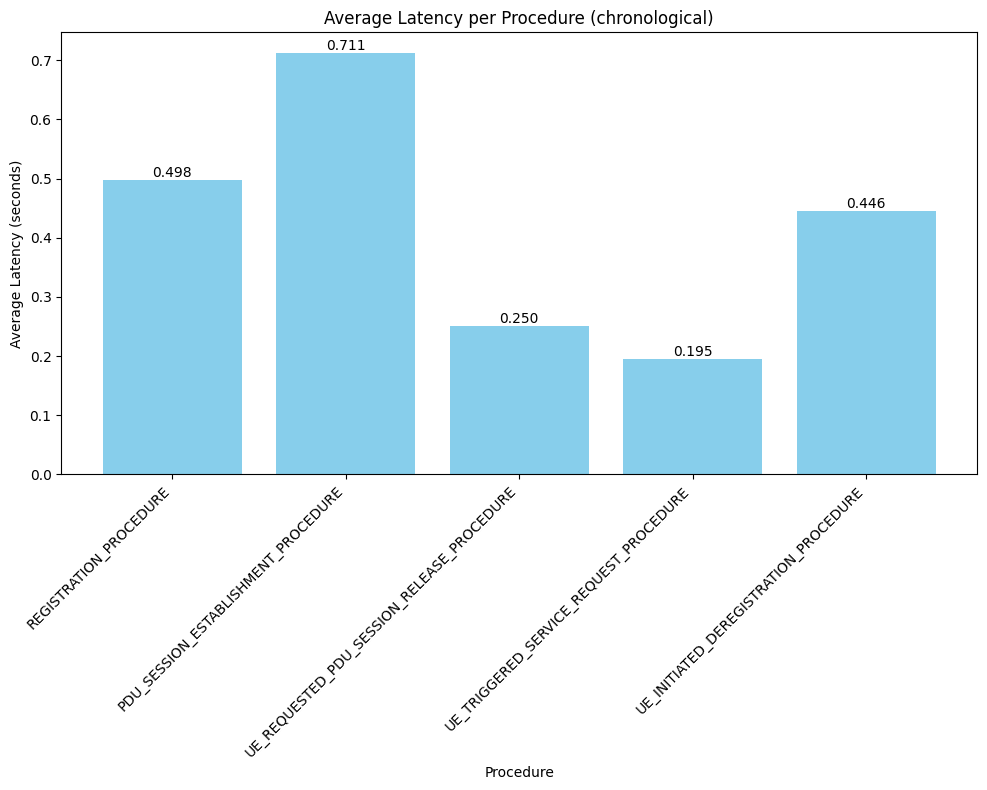

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Suppose your latency_df is already created:
latency_df = compute_procedure_latencies(df)

grouped = latency_df.groupby("procedure").agg(
    count=("latency_us", "count"),
    avg_latency_us=("latency_us", "mean")
).reset_index()
grouped['avg_latency_sec'] = grouped['avg_latency_us'] / 1e6

# 1) Define a custom procedure order:
procedure_order = [
    "REGISTRATION_PROCEDURE",
    "PDU_SESSION_ESTABLISHMENT_PROCEDURE",
    "UE_REQUESTED_PDU_SESSION_RELEASE_PROCEDURE",
    "UE_TRIGGERED_SERVICE_REQUEST_PROCEDURE",
    "UE_INITIATED_DEREGISTRATION_PROCEDURE"
]

# 2) Convert the 'procedure' column into a categorical with this order:
grouped['procedure'] = pd.Categorical(
    grouped['procedure'],
    categories=procedure_order,
    ordered=True
)

# 3) Now sort by 'procedure' (the custom categorical order):
grouped = grouped.sort_values("procedure")

# 4) Plot a bar chart using this new order:
plt.figure(figsize=(10, 8))
bars = plt.bar(grouped['procedure'], grouped['avg_latency_sec'], color='skyblue')
plt.xlabel("Procedure")
plt.ylabel("Average Latency (seconds)")
plt.title("Average Latency per Procedure (chronological)")
plt.xticks(rotation=45, ha='right')

for bar, latency in zip(bars, grouped['avg_latency_sec']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             f"{latency:.3f}", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig("average_latency_per_procedure.png", dpi=300, format='png')
plt.show()


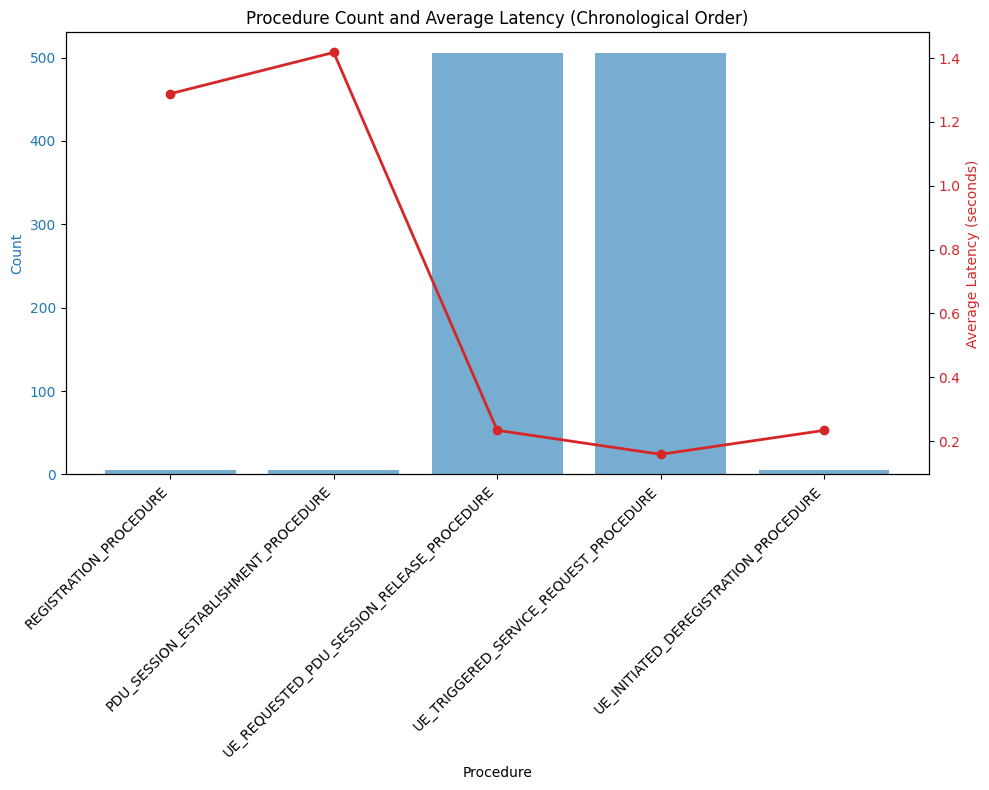

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Suppose 'latency_df' is already created via compute_procedure_latencies(df).
latency_df = compute_procedure_latencies(df)

grouped = latency_df.groupby("procedure").agg(
    count=("latency_us", "count"),
    avg_latency_us=("latency_us", "mean")
).reset_index()
grouped['avg_latency_sec'] = grouped['avg_latency_us'] / 1e6

# 1) Define your custom chronological order for the procedures.
procedure_order = [
    "REGISTRATION_PROCEDURE",
    "PDU_SESSION_ESTABLISHMENT_PROCEDURE",
    "UE_REQUESTED_PDU_SESSION_RELEASE_PROCEDURE",
    "UE_TRIGGERED_SERVICE_REQUEST_PROCEDURE",
    "UE_INITIATED_DEREGISTRATION_PROCEDURE"
]

# 2) Convert 'procedure' to a categorical with this custom order.
grouped['procedure'] = pd.Categorical(
    grouped['procedure'],
    categories=procedure_order,
    ordered=True
)

# 3) Sort by this categorical order instead of by 'count'.
grouped = grouped.sort_values("procedure")

# 4) Now create your dual-axis plot using the new, sorted DataFrame.
fig, ax1 = plt.subplots(figsize=(10, 8))

# Bar chart (count) on the primary y-axis
color1 = 'tab:blue'
ax1.set_xlabel("Procedure")
ax1.set_ylabel("Count", color=color1)
ax1.bar(grouped['procedure'], grouped['count'], color=color1, alpha=0.6, label="Count")
ax1.tick_params(axis='y', labelcolor=color1)
plt.xticks(rotation=45, ha='right')

# Create a second y-axis for average latency
ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel("Average Latency (seconds)", color=color2)
ax2.plot(grouped['procedure'], grouped['avg_latency_sec'], color=color2, marker='o', linewidth=2, label="Avg Latency")
ax2.tick_params(axis='y', labelcolor=color2)

plt.title("Procedure Count and Average Latency (Chronological Order)")
fig.tight_layout()
plt.savefig("Procedure_Count_and_Average_Latency_Chronological.png", dpi=300, format='png')
plt.show()


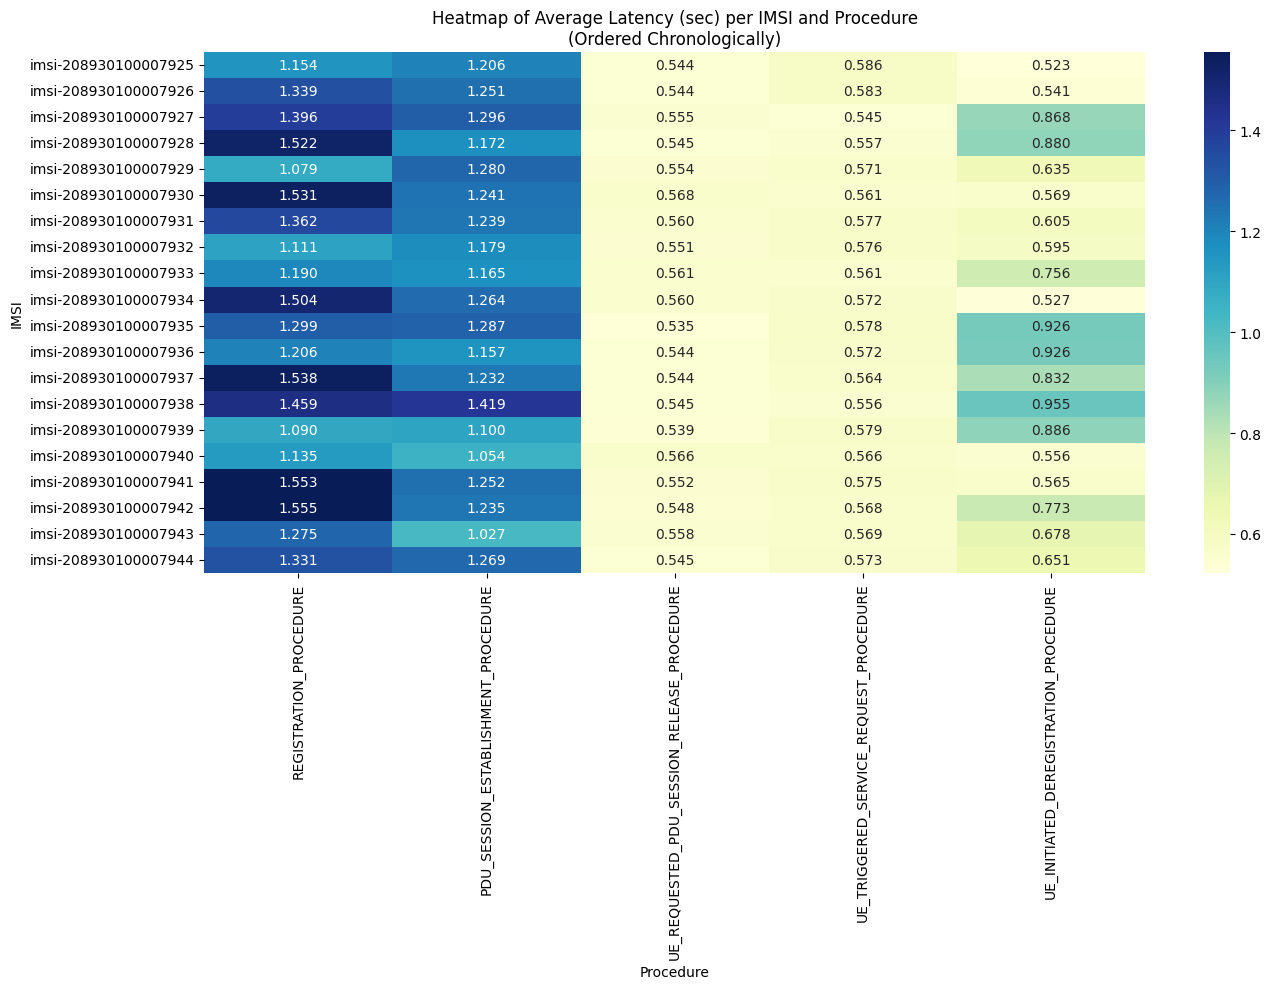

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Clean the imsi column to remove trailing commas and extra whitespace
latency_df['imsi'] = latency_df['imsi'].str.strip().str.rstrip(',')

# Ensure latency_df has a latency_sec column (convert microseconds to seconds)
latency_df['latency_sec'] = latency_df['latency_us'] / 1e6

# Create a pivot table: rows are IMSIs, columns are procedures, values are average latency (sec)
pivot = latency_df.pivot_table(index="imsi", columns="procedure", values="latency_sec", aggfunc="mean")

# Define the custom procedure order (adjust these names to match your data)
desired_order = [
    "REGISTRATION_PROCEDURE",
    "PDU_SESSION_ESTABLISHMENT_PROCEDURE",
    "UE_REQUESTED_PDU_SESSION_RELEASE_PROCEDURE",
    "UE_TRIGGERED_SERVICE_REQUEST_PROCEDURE",
    "UE_INITIATED_DEREGISTRATION_PROCEDURE"
]

# Reorder the columns of the pivot table based on desired_order.
# If a procedure in desired_order is not present, reindex will create a column with NaN.
pivot = pivot.reindex(columns=desired_order)

# For example, show only top 20 IMSIs by count:
imsi_counts = latency_df['imsi'].value_counts().head(20)
filtered_pivot = pivot.loc[imsi_counts.index]

plt.figure(figsize=(14, 10))
sns.heatmap(filtered_pivot, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("Heatmap of Average Latency (sec) per IMSI and Procedure\n(Ordered Chronologically)")
plt.xlabel("Procedure")
plt.ylabel("IMSI")
plt.tight_layout()
plt.savefig("heatmap_of_average_latency_per_imsi_and_procedure.png", dpi=300, format='png')
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 95.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 95.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 96.6% of the points cannot be plac

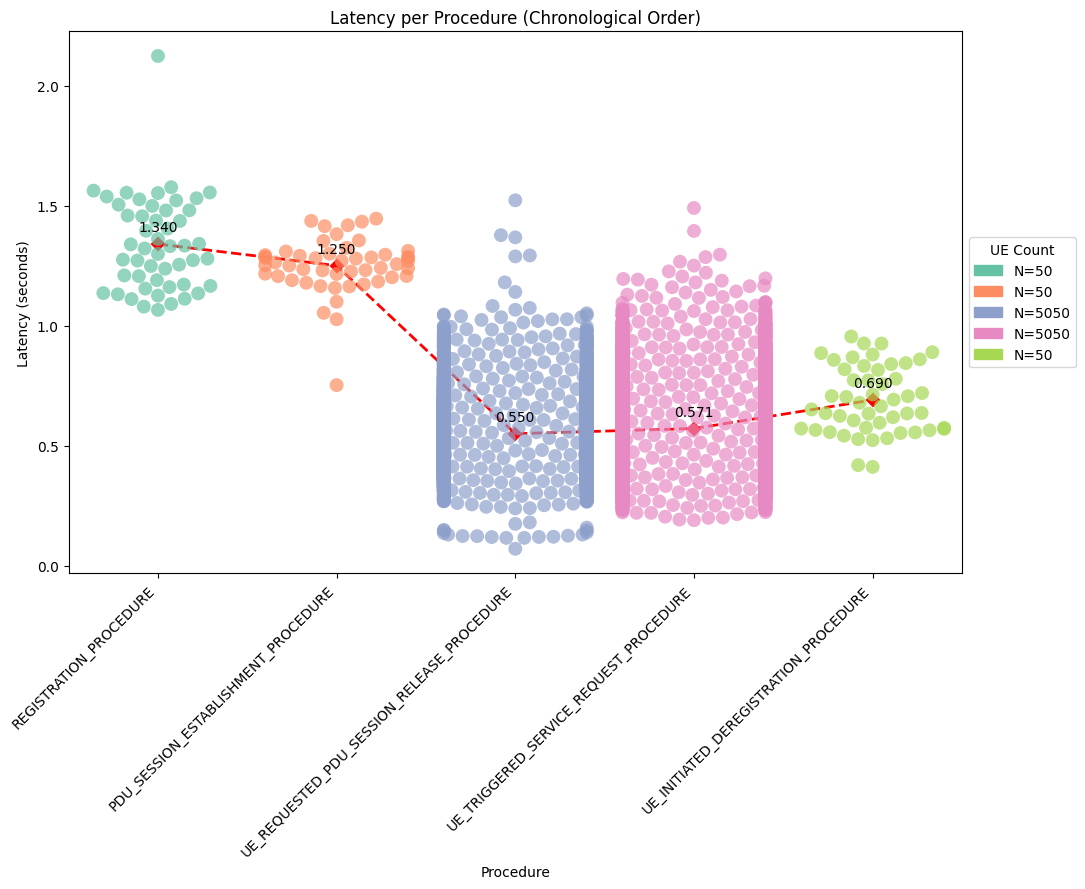

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as mpatches

# Step 1: Convert latency values from microseconds to seconds.
latency_df['latency_sec'] = latency_df['latency_us'] / 1e6

# Step 2: Compute overall average latency per procedure.
grouped = latency_df.groupby("procedure", observed=False).agg(
    count=("latency_us", "count"),
    avg_latency_us=("latency_us", "mean")
).reset_index()
grouped['avg_latency_sec'] = grouped['avg_latency_us'] / 1e6

# -----------------------------------------------------------------------------
# Step 3: Define the desired chronological order for the procedures.
# -----------------------------------------------------------------------------
desired_order = [
    "REGISTRATION_PROCEDURE",
    "PDU_SESSION_ESTABLISHMENT_PROCEDURE",
    "UE_REQUESTED_PDU_SESSION_RELEASE_PROCEDURE",
    "UE_TRIGGERED_SERVICE_REQUEST_PROCEDURE",
    "UE_INITIATED_DEREGISTRATION_PROCEDURE"
]

# Convert the 'procedure' column to a categorical with the custom order.
grouped['procedure'] = pd.Categorical(grouped['procedure'], categories=desired_order, ordered=True)
latency_df['procedure'] = pd.Categorical(latency_df['procedure'], categories=desired_order, ordered=True)

# Now sort the grouped DataFrame by the custom procedure order.
grouped = grouped.sort_values("procedure")
order = grouped['procedure'].tolist()

# -----------------------------------------------------------------------------
# Step 4: Create a color palette mapping each procedure to a distinct color.
# -----------------------------------------------------------------------------
palette = sns.color_palette("Set2", n_colors=len(order))
proc_color_map = dict(zip(order, palette))

# -----------------------------------------------------------------------------
# Step 5: Plotting - Create a Dual-Axis Plot with procedures in chronological order.
# -----------------------------------------------------------------------------
plt.figure(figsize=(11, 9))

# Swarm plot for individual IMSI latency values.
ax = sns.swarmplot(
    x="procedure", y="latency_sec", data=latency_df,
    hue="procedure", order=order, dodge=False,
    palette=proc_color_map, size=10, alpha=0.7
)

# Remove the legend produced by the swarm plot.
leg = ax.get_legend()
if leg is not None:
    leg.remove()

# Overlay the overall average latency using a point plot.
sns.pointplot(
    x="procedure", y="avg_latency_sec", data=grouped, order=order,
    color="red", markers="D", linestyles="--", markersize=6, linewidth=2
)

# Annotate each average point with its average latency value.
for i, row in enumerate(grouped.itertuples(), start=0):
    plt.text(i, row.avg_latency_sec + 0.04, f"{row.avg_latency_sec:.3f}",
             ha="center", va="bottom", color="black", fontsize=10)

# -----------------------------------------------------------------------------
# Step 6: Create a custom legend on the right side showing only the UE count.
# -----------------------------------------------------------------------------
legend_handles = []
for _, row in grouped.iterrows():
    # Use only the UE count (without the procedure name)
    count_val = int(row['count'])
    color = proc_color_map[row['procedure']]
    # Create a patch with label "N=xxx"
    patch = mpatches.Patch(color=color, label=f"N={count_val}")
    legend_handles.append(patch)

# Place the custom legend on the right.
plt.legend(handles=legend_handles, title="UE Count", loc="center left", bbox_to_anchor=(1, 0.5))

plt.xlabel("Procedure")
plt.ylabel("Latency (seconds)")
plt.title("Latency per Procedure (Chronological Order)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("latency_per_procedure_chronological.png", dpi=300, format='png')
plt.show()


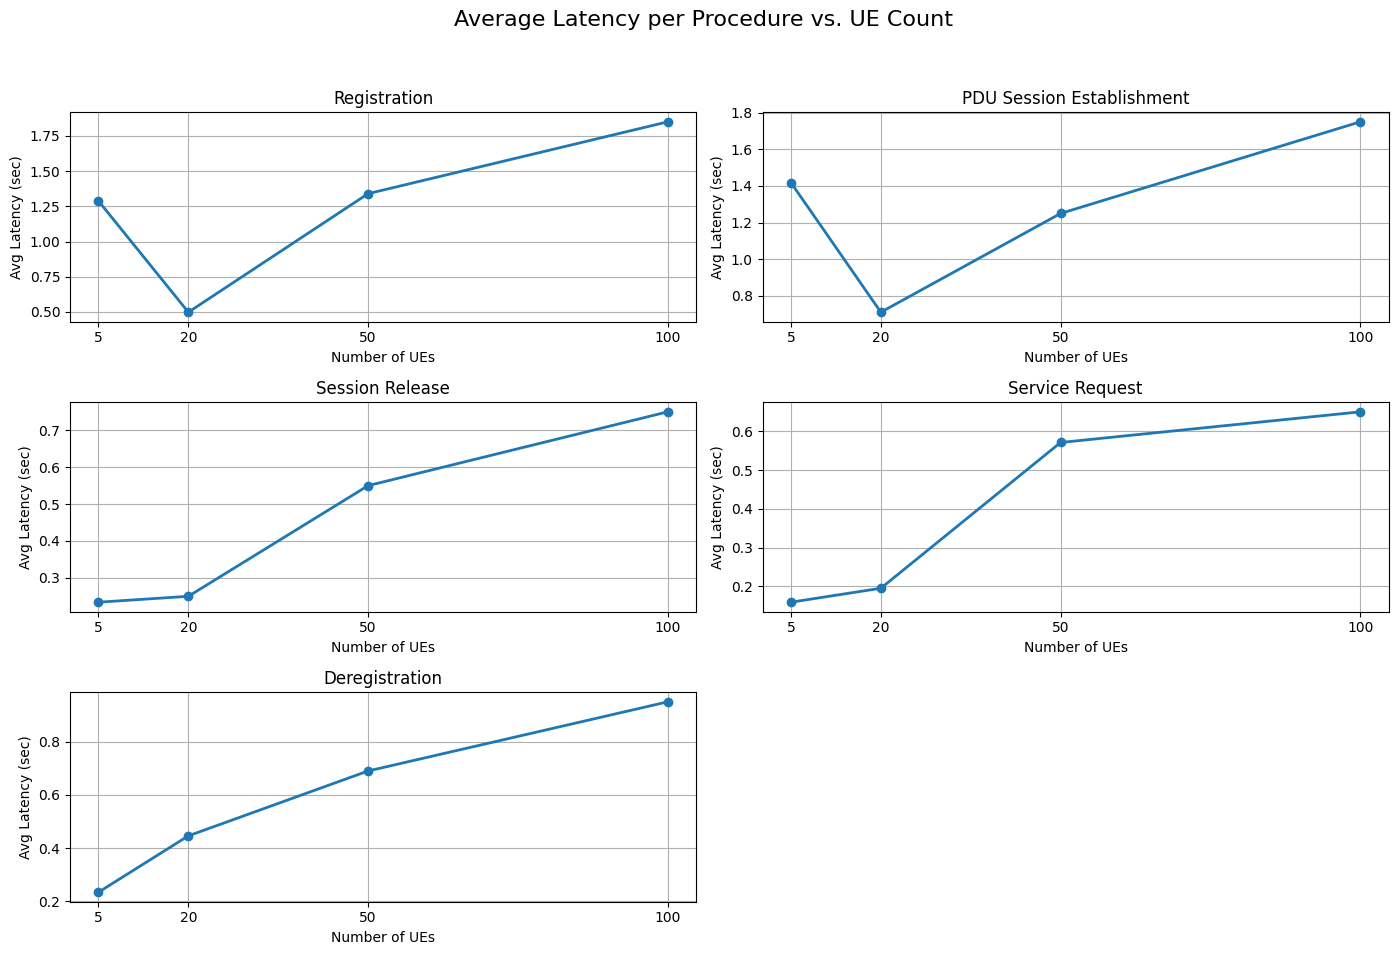

In [14]:
import matplotlib.pyplot as plt

# UE counts for each test case
ue_counts = [5, 20, 50, 100]

# Average latency (in seconds) per procedure
latencies = {
    "Registration": [1.288, 0.498, 1.340, 1.85],
    "PDU Session Establishment": [1.418, 0.711, 1.250, 1.75],
    "Session Release": [0.234, 0.250, 0.550, 0.75],
    "Service Request": [0.159, 0.195, 0.571, 0.65],
    "Deregistration": [0.234, 0.446, 0.690, 0.95]
}

# Create subplots
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(14, 10))
axs = axs.flatten()

# Plot each procedure in its own subplot
for i, (procedure, values) in enumerate(latencies.items()):
    axs[i].plot(ue_counts, values, marker='o', linestyle='-', linewidth=2)
    axs[i].set_title(procedure)
    axs[i].set_xlabel("Number of UEs")
    axs[i].set_ylabel("Avg Latency (sec)")
    axs[i].grid(True)
    axs[i].set_xticks(ue_counts)

# Hide the unused subplot (since we have 5 procedures)
for j in range(len(latencies), len(axs)):
    fig.delaxes(axs[j])

# Super title for the entire figure
fig.suptitle("Average Latency per Procedure vs. UE Count", fontsize=16)

# Adjust layout and save the figure
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("avg_latency_vs_ue_count_procedures_600dpi.png", dpi=600, bbox_inches='tight')
plt.show()
